In [1]:
import pandas as pd
import torch
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import tensorflow_hub as hub

import torch.nn as nn
from transformers import AutoModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import torch.optim as optim
import torch.nn.functional as F

import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

import optuna

from helper import cosine_similarity_mean_median, compute_tfidf_similarity, compute_pearson_correlation

In [2]:
# train 70%, val 20%, test 10%
#df = pd.read_csv("Research_Papers_Dataset_clean.csv")
df = pd.read_csv("database_clean.csv")
df = df.dropna(subset=['title', 'abstract'])
#df = df.head(10000)
df.reset_index(drop=True, inplace=True)

X_train, X_temp = train_test_split(df, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=1/3, random_state=42)
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (7745, 8), Validation: (2213, 8), Test: (1107, 8)


In [3]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/distiluse-base-multilingual-cased-v1")

class PaperDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        title = str(self.data.iloc[idx]["title"])
        abstract = str(self.data.iloc[idx]["abstract"])
        input_text = title + " " + abstract  # Combine title and abstract
        
        tokens = self.tokenizer(
            input_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "paper_index": idx  # Used for retrieval
        }

# Create dataset and DataLoader
dataset_train = PaperDataset(X_train, tokenizer, 256)
dataset_val = PaperDataset(X_val, tokenizer, 256)
dataloader = DataLoader(dataset_train, batch_size=8, shuffle=True)

In [4]:
for batch in dataloader:
    print("Batch Input IDs Shape:", batch["input_ids"].shape)
    print("Batch Attention Mask Shape:", batch["attention_mask"].shape)
    break  # Check only the first batch

Batch Input IDs Shape: torch.Size([8, 256])
Batch Attention Mask Shape: torch.Size([8, 256])


In [5]:
class PaperRecommender(nn.Module):
    def __init__(self, model_name, embedding_dim, num_heads, dropout):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.embedding_dim = embedding_dim  # Ensure this is correctly set

        # Ensure projection layer matches `embedding_dim`
        self.fc = nn.Linear(self.encoder.config.hidden_size, embedding_dim)  
        
        # Multiheaded attention layer using the correct `embedding_dim`
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout)

        self.dropout = nn.Dropout(dropout)
        self.normalize = nn.functional.normalize

    def forward(self, input_ids, attention_mask):
        input_ids = input_ids.to(next(self.parameters()).device)
        attention_mask = attention_mask.to(next(self.parameters()).device)

        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token representation

        embedding = self.fc(self.dropout(pooled_output))  # Apply projection
        embedding = embedding.unsqueeze(0)  # Reshape for MultiheadAttention

        # Multiheaded Attention
        attn_output, _ = self.attention(embedding, embedding, embedding)
        attn_output = attn_output.squeeze(0)  # Remove batch dim

        return self.normalize(attn_output, p=2, dim=1)  # Normalize embeddings

In [6]:
def compute_tfidf_similarity_matrix(df):
    corpus = df['title'] + " " + df['abstract']
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    return similarity_matrix

similarity_matrix_np = compute_tfidf_similarity_matrix(df)
# Convert to tensor for GPU computation
similarity_matrix = torch.tensor(similarity_matrix_np, dtype=torch.float32).to("cuda")
print(similarity_matrix)

threshold = 0.0785

positive_pairs = similarity_matrix > threshold
negative_pairs = ~positive_pairs
print(positive_pairs)
print(negative_pairs)

tensor([[1.0000, 0.0315, 0.0706,  ..., 0.0540, 0.0357, 0.0396],
        [0.0315, 1.0000, 0.0360,  ..., 0.0391, 0.0290, 0.0229],
        [0.0706, 0.0360, 1.0000,  ..., 0.0709, 0.0375, 0.0412],
        ...,
        [0.0540, 0.0391, 0.0709,  ..., 1.0000, 0.0511, 0.0347],
        [0.0357, 0.0290, 0.0375,  ..., 0.0511, 1.0000, 0.0244],
        [0.0396, 0.0229, 0.0412,  ..., 0.0347, 0.0244, 1.0000]],
       device='cuda:0')
tensor([[ True, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False,  True]], device='cuda:0')
tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ Tr

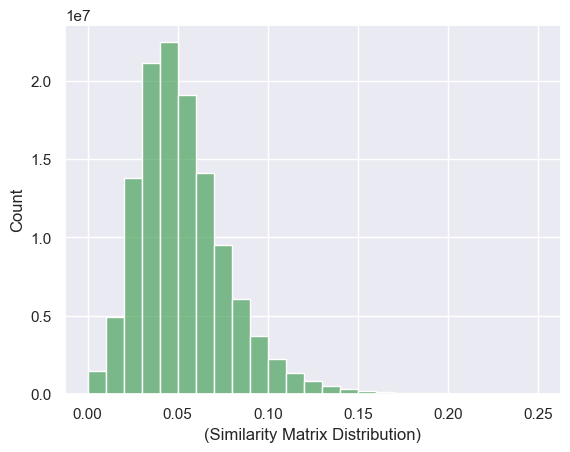

85th percentile: 0.0769
90th percentile: 0.0854
95th percentile: 0.0998


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#Organize Data
similarity_values_np = similarity_matrix_np.flatten()
similarity_values_np_filtered = similarity_values_np[similarity_values_np <= 0.25]
X = pd.Series(similarity_values_np_filtered, name="(Similarity Matrix Distribution)")

#Plot Data
fig, ax = plt.subplots()
sns.histplot(X, bins=25, color="g", ax=ax)
plt.show()

# Compute percentiles
percentiles = [85, 90, 95]
percentile_values = np.percentile(similarity_values_np_filtered, percentiles)

# Print results
for p, val in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {val:.4f}")

In [8]:
def save_model(model, optimizer, epoch, loss, path="./paper_recommender_Large.pth"):
    """Save the model, optimizer state, and training metadata."""
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss
    }
    torch.save(checkpoint, path)
    print(f"Model saved at {path}")

In [9]:
def load_model(model, optimizer=None, path = "./paper_recommender_Large.pth"):
    """Load the model and optionally the optimizer."""
    checkpoint = torch.load(path, map_location="cuda" if torch.cuda.is_available() else "cpu")
    
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Model loaded from {path}, trained until epoch {checkpoint['epoch']}")
    
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print("Optimizer state restored.")

    return checkpoint["epoch"], checkpoint["loss"]

In [10]:
def contrastive_loss(embeddings, similarity_matrix, indices, margin=0.5):
    """
    Contrastive loss using TF-IDF similarity as ground truth.
    
    embeddings: (batch_size, embedding_dim)
    similarity_matrix: Precomputed TF-IDF cosine similarity.
    indices: Indices of batch samples in dataset.
    margin: Margin for contrastive loss.
    """
    batch_size = embeddings.shape[0]

    # Ensure embeddings are L2 normalized
    embeddings = F.normalize(embeddings, p=2, dim=1)

    # Compute cosine similarity
    cosine_sim = torch.mm(embeddings, embeddings.T)  # (batch_size, batch_size)
    cosine_distances = 1 - cosine_sim  # Convert similarity to distance

    # Extract ground truth similarity values for batch samples
    ground_truth_similarities = similarity_matrix[indices][:, indices]

    # Define positive and negative pairs
    threshold = 0.1205  # Adjust this value if needed
    positive_pairs = (ground_truth_similarities > threshold).float()
    negative_pairs = (ground_truth_similarities <= threshold).float()

    # Compute losses
    positive_loss = (cosine_distances * positive_pairs).sum() / (positive_pairs.sum() + 1e-8)
    negative_loss = torch.clamp(margin - cosine_distances, min=0) * negative_pairs
    negative_loss = negative_loss.sum() / (negative_pairs.sum() + 1e-8)

    loss = positive_loss + negative_loss

    return loss


In [11]:
def objective(trial):
    # Define hyperparameter search space
    embedding_dim = trial.suggest_categorical("embedding_dim", [256, 512, 768])
    num_heads = trial.suggest_categorical("num_heads", [2,4,8,16])
    dropout = trial.suggest_float("dropout", 0.1, 0.3)

    # Initialize model with selected hyperparameters
    model = PaperRecommender("sentence-transformers/distiluse-base-multilingual-cased-v1",
                             embedding_dim, num_heads, dropout).to("cuda")
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    # Create train and validation dataloaders
    dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)
    dataloader_val = DataLoader(dataset_val, batch_size=8, shuffle=False)

    num_epochs = 3  # Use fewer epochs for tuning
    total_loss = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch in dataloader_train:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            indices = batch["paper_index"].cpu().numpy()

            optimizer.zero_grad()
            embeddings = model(input_ids, attention_mask)

            loss = contrastive_loss(embeddings, similarity_matrix, indices, margin=0.5)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(dataloader_train)

        # Validation step (compute loss on validation set)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in dataloader_val:
                input_ids = batch["input_ids"].to("cuda")
                attention_mask = batch["attention_mask"].to("cuda")
                indices = batch["paper_index"].cpu().numpy()

                embeddings = model(input_ids, attention_mask)
                val_loss += contrastive_loss(embeddings, similarity_matrix, indices, margin=0.5).item()

        avg_val_loss = val_loss / len(dataloader_val)
        total_loss += avg_val_loss

    return total_loss / num_epochs  # Minimize validation loss

In [12]:
study = optuna.create_study(direction="minimize")  # We want to minimize loss
study.optimize(objective, n_trials=20)  # Run 20 trials

print("Best hyperparameters:", study.best_params)

[I 2025-03-22 10:40:58,448] A new study created in memory with name: no-name-ba3f3067-c3c0-48f3-8087-df69d676aedf
[I 2025-03-22 11:11:03,899] Trial 0 finished with value: 0.09098326430212489 and parameters: {'embedding_dim': 512, 'num_heads': 8, 'dropout': 0.14380577624493165}. Best is trial 0 with value: 0.09098326430212489.
[I 2025-03-22 11:38:33,280] Trial 1 finished with value: 0.19301498531577965 and parameters: {'embedding_dim': 512, 'num_heads': 8, 'dropout': 0.2704141693905229}. Best is trial 0 with value: 0.09098326430212489.
[I 2025-03-22 12:05:56,476] Trial 2 finished with value: 0.10596397437018519 and parameters: {'embedding_dim': 512, 'num_heads': 4, 'dropout': 0.1856256086503944}. Best is trial 0 with value: 0.09098326430212489.
[I 2025-03-22 12:33:12,648] Trial 3 finished with value: 0.23747724854128457 and parameters: {'embedding_dim': 512, 'num_heads': 4, 'dropout': 0.2837015151771267}. Best is trial 0 with value: 0.09098326430212489.
[I 2025-03-22 13:00:24,499] Trial

Best hyperparameters: {'embedding_dim': 768, 'num_heads': 2, 'dropout': 0.1000802102003194}


In [13]:
# Initialize model
model = PaperRecommender("sentence-transformers/distiluse-base-multilingual-cased-v1",
                               study.best_params["embedding_dim"],
                               study.best_params["num_heads"],
                               study.best_params["dropout"]).to("cuda")

optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        indices = batch["paper_index"].cpu().numpy()

        optimizer.zero_grad()
        embeddings = model(input_ids, attention_mask)

        loss = contrastive_loss(embeddings, similarity_matrix, indices, margin=0.5)

        if loss.item() == 0:
            print(f"Warning: Zero loss at epoch {epoch+1}. Debug required.")
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")
    save_model(model, optimizer, epoch + 1, avg_loss, "paper_recommender_Large.pth")


Epoch 1, Avg Loss: 0.0603
Model saved at paper_recommender_Large.pth
Epoch 2, Avg Loss: 0.0617
Model saved at paper_recommender_Large.pth
Epoch 3, Avg Loss: 0.0629
Model saved at paper_recommender_Large.pth
Epoch 4, Avg Loss: 0.0620
Model saved at paper_recommender_Large.pth
Epoch 5, Avg Loss: 0.0602
Model saved at paper_recommender_Large.pth
Epoch 6, Avg Loss: 0.0592
Model saved at paper_recommender_Large.pth
Epoch 7, Avg Loss: 0.0613
Model saved at paper_recommender_Large.pth
Epoch 8, Avg Loss: 0.0583
Model saved at paper_recommender_Large.pth
Epoch 9, Avg Loss: 0.0610
Model saved at paper_recommender_Large.pth
Epoch 10, Avg Loss: 0.0618
Model saved at paper_recommender_Large.pth


In [16]:
# Initialize model
model = PaperRecommender("sentence-transformers/distiluse-base-multilingual-cased-v1",
                               768,
                               2,
                               0.1).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Load the model (after training)
epoch, loss = load_model(model, optimizer, "paper_recommender_Large.pth")
model.eval()  # Set to evaluation mode

Model loaded from paper_recommender_Large.pth, trained until epoch 10
Optimizer state restored.


PaperRecommender(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [17]:
def recommend_papers(query, model, df, top_k=5):
    model.eval()
    
    # Tokenize and encode query
    query_tokens = tokenizer(query, padding="max_length", truncation=True, max_length=512, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        query_embedding = model(query_tokens["input_ids"], query_tokens["attention_mask"]).cpu().numpy()

    # Compute Euclidean distances between query and all paper embeddings
    paper_embeddings = []
    paper_indices = []

    for batch in dataloader:
        batch_input_ids = batch["input_ids"].to("cuda")
        batch_attention_mask = batch["attention_mask"].to("cuda")

        with torch.no_grad():
            batch_embeddings = model(batch_input_ids, batch_attention_mask).cpu().numpy()
            paper_embeddings.append(batch_embeddings)
            paper_indices.extend(batch["paper_index"].numpy())  # Store original indices

    paper_embeddings = np.vstack(paper_embeddings)  # Stack all embeddings
    paper_indices = np.array(paper_indices)

    # Compute pairwise Euclidean distances
    distances = np.linalg.norm(paper_embeddings - query_embedding, axis=1)

    # Get top-k closest papers (smallest distances)
    top_indices = np.argsort(distances)[:top_k]

    print("\nRecommended Papers:")
    for idx in top_indices:
        paper_idx = paper_indices[idx]
        print(f"Title: {df.iloc[paper_idx]['title']}\nAbstract: {df.iloc[paper_idx]['abstract']}\nDistance: {distances[idx]:.4f}\n")

In [18]:
recommend_papers("deep learning for edge computing", model, df)


Recommended Papers:
Title: Tactile brain-computer interface using classification of P300 responses evoked by full body spatial vibrotactile stimuli
Abstract: In this study we propose a novel stimulus-driven brain-computer interface (BCI) paradigm, which generates control commands based on classification of somatosensory modality P300 responses. Six spatial vibrotactile stimulus patterns are applied to entire back and limbs of a user. The aim of the current project is to validate an effectiveness of the vibrotactile stimulus patterns for BCI purposes and to establish a novel concept of tactile modality communication link, which shall help locked-in syndrome (LIS) patients, who lose their sight and hearing due to sensory disabilities. We define this approach as a full-body BCI (fbBCI) and we conduct psychophysical stimulus evaluation and realtime EEG response classification experiments with ten healthy body-able users. The grand mean averaged psychophysical stimulus pattern recognition 

In [19]:
# Generate embeddings for all papers using the trained model
def get_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    paper_indices = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")

            batch_embeddings = model(input_ids, attention_mask)  # Keep as CUDA tensor
            embeddings.append(batch_embeddings)  # Store without converting to NumPy
            paper_indices.extend(batch["paper_index"].numpy())

    return torch.cat(embeddings, dim=0), np.array(paper_indices)  # Return PyTorch tensor

# Get embeddings for train and test sets
train_dataloader = DataLoader(PaperDataset(X_train, tokenizer, 256), batch_size=8, shuffle=False)
test_dataloader = DataLoader(PaperDataset(X_test, tokenizer, 256), batch_size=8, shuffle=False)

train_embeddings, train_indices = get_embeddings(train_dataloader, model)
test_embeddings, test_indices = get_embeddings(test_dataloader, model)

# Compute cosine similarity in CUDA
train_embeddings = F.normalize(train_embeddings, p=2, dim=1)  # Normalize embeddings
test_embeddings = F.normalize(test_embeddings, p=2, dim=1)

print("Sample Test Embedding:", test_embeddings[0][:15])  # First 15 values
print("Sample Train Embedding:", train_embeddings[0][:15])  # First 15 values

similarity_matrix = torch.matmul(test_embeddings, train_embeddings.T).cpu().numpy()  # Cosine similarity

# Select top-N most similar papers
top_n = 10
top_indices = np.argsort(-similarity_matrix, axis=1)[:, :top_n]

# Print recommended papers
recommended_paper_ids = []

for i, test_idx in enumerate(top_indices):
    recommended_for_test = []
    #print(f"\nTest Paper {i+1}:")
    
    for j, train_idx in enumerate(test_idx):
        recommended_paper_id = X_train.iloc[train_indices[train_idx]]["id"]
        recommended_for_test.append(recommended_paper_id)
        
        #print(f"  {j+1}. Recommended Paper ID: {recommended_paper_id} (Similarity: {similarity_matrix[i, train_idx]:.4f})")
    
    recommended_paper_ids.append(recommended_for_test)

Sample Test Embedding: tensor([ 0.0484, -0.0271, -0.0472,  0.0290, -0.0463, -0.0087, -0.0113,  0.0026,
        -0.0633, -0.0120,  0.0005,  0.0405,  0.0290, -0.0201, -0.0131],
       device='cuda:0')
Sample Train Embedding: tensor([ 0.0332, -0.0545, -0.0365, -0.0274, -0.0683,  0.0369, -0.0212,  0.0079,
        -0.0702,  0.0382,  0.0248,  0.0978, -0.0342,  0.0356, -0.0411],
       device='cuda:0')

Test Paper 1:

Test Paper 2:

Test Paper 3:

Test Paper 4:

Test Paper 5:

Test Paper 6:

Test Paper 7:

Test Paper 8:

Test Paper 9:

Test Paper 10:

Test Paper 11:

Test Paper 12:

Test Paper 13:

Test Paper 14:

Test Paper 15:

Test Paper 16:

Test Paper 17:

Test Paper 18:

Test Paper 19:

Test Paper 20:

Test Paper 21:

Test Paper 22:

Test Paper 23:

Test Paper 24:

Test Paper 25:

Test Paper 26:

Test Paper 27:

Test Paper 28:

Test Paper 29:

Test Paper 30:

Test Paper 31:

Test Paper 32:

Test Paper 33:

Test Paper 34:

Test Paper 35:

Test Paper 36:

Test Paper 37:

Test Paper 38:

T

In [20]:
cosine_mean, cosine_median = cosine_similarity_mean_median(similarity_matrix)

print("Mean Cosine Similarity (Top 10):", np.mean(cosine_mean))
print("Median Cosine Similarity (Top 10):", np.mean(cosine_median))

Mean Cosine Similarity (Top 10): 0.691122
Median Cosine Similarity (Top 10): 0.68674666


In [27]:
# Get test paper texts
test_texts = (X_test["title"] + " " + X_test["abstract"]).tolist()

top10_texts = []
top10_embeddings = []

for i in range(len(top_indices)):
    top_paper_texts = []
    top_paper_embeds = []

    for j in top_indices[i]:
        paper = X_train.iloc[train_indices[j]]
        text = paper["title"] + " " + paper["abstract"]
        top_paper_texts.append(text)

        # Detach from graph, move to CPU, then convert to NumPy
        vector = train_embeddings[j].detach().cpu().numpy()
        top_paper_embeds.append(vector)

    top10_texts.append(top_paper_texts)
    top10_embeddings.append(top_paper_embeds)

top10_embeddings = np.array(top10_embeddings)  # Shape: (num_test, 10, embedding_dim)

In [28]:
tfidf_matrix, tfidf_test_vecs, tfidf_top10_vecs = compute_tfidf_similarity(test_texts, top10_texts)

# Optionally compare TF-IDF vectors
print("TF-IDF Shape (Test):", tfidf_test_vecs.shape)
print("TF-IDF Shape (Top 10):", tfidf_top10_vecs.shape)

TF-IDF Shape (Test): (1107, 5000)
TF-IDF Shape (Top 10): (1107, 10, 5000)


In [29]:
# Move test embeddings to CPU and convert to NumPy
test_embeddings_np = test_embeddings.detach().cpu().numpy()

# top10_embeddings should already be NumPy from the earlier fix
# (check if needed: top10_embeddings = np.array([...]) was already done)

# Now call the Pearson correlation evaluator
pearson_mean, pearson_median = compute_pearson_correlation(test_embeddings_np, top10_embeddings)

print("Mean Pearson Correlation (Top 10):", np.mean(pearson_mean))
print("Median Pearson Correlation (Top 10):", np.mean(pearson_median))

Mean Pearson Correlation (Top 10): 0.6913492523396649
Median Pearson Correlation (Top 10): 0.6869894434565695
